In [1]:
import pandas as pd
import json
import os
import snowflake.snowpark.functions as F
from snowflake.snowpark import Session
from dotenv import load_dotenv
from snowflake.connector.pandas_tools import write_pandas
import snowflake.connector
from snowflake.snowpark import Session
import numpy as np

In [2]:
load_dotenv(".env")
conn = snowflake.connector.connect(
    user=os.getenv("SNOWFLAKE_USER"),
    password=os.getenv("SNOWFLAKE_PASSWORD"),
    account=os.getenv("SNOWFLAKE_ACCOUNT"),
    warehouse=os.getenv("SNOWFLAKE_WAREHOUSE"),
    database=os.getenv("SNOWFLAKE_DATABASE"),
    schema=os.getenv("SNOWFLAKE_SCHEMA"),
    role =os.getenv("SNOWFLAKE_ROLE")
)

In [3]:
import os
connection_parameters = {
    "user": os.getenv("SNOWFLAKE_USER"),
    "password": os.getenv("SNOWFLAKE_PASSWORD"),
    "account": os.getenv("SNOWFLAKE_ACCOUNT"),
    "warehouse": os.getenv("SNOWFLAKE_WAREHOUSE"),
    "database": os.getenv("SNOWFLAKE_DATABASE"),
    "schema": os.getenv("SNOWFLAKE_SCHEMA"),
    "role": os.getenv("SNOWFLAKE_ROLE")
}


In [4]:
session = Session.builder.configs(connection_parameters).create()

In [5]:
try:
    df = session.table('"datapicture"') 
   
except Exception as e:
    df = session.table("DATAPICTURE")
  

In [6]:
df_pandas =df.toPandas()
df_pandas.head()

,column0,column1,column2,column3,column4,column5,column6,column7,column8,column9,...,column9991,column9992,column9993,column9994,column9995,column9996,column9997,column9998,column9999,column10000
0,0.752941,0.752941,0.756863,0.768627,0.752941,0.756863,0.760784,0.745098,0.745098,0.768627,...,0.862745,0.874510,0.874510,0.713725,0.431373,0.431373,0.431373,0.431373,0.431373,Female
1,0.635294,0.709804,0.827451,0.882353,0.894118,0.882353,0.894118,0.866667,0.878431,0.858824,...,0.666667,0.662745,0.650980,0.658824,0.650980,0.643137,0.643137,0.631373,0.643137,Male
2,0.360784,0.388235,0.345098,0.294118,0.309804,0.321569,0.317647,0.290196,0.282353,0.294118,...,0.760784,0.729412,0.690196,0.639216,0.576471,0.545098,0.545098,0.552941,0.552941,Female
3,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.988235,0.960784,...,0.541176,0.501961,0.505882,0.698039,0.909804,0.913725,0.909804,0.901961,0.909804,Female
4,0.435294,0.439216,0.462745,0.462745,0.466667,0.478431,0.443137,0.435294,0.454902,0.458824,...,0.078431,0.086275,0.086275,0.086275,0.086275,0.078431,0.074510,0.086275,0.094118,Male


In [7]:
df_pandas.columns

Index(['column0', 'column1', 'column2', 'column3', 'column4', 'column5',
       'column6', 'column7', 'column8', 'column9',
       ...
       'column9991', 'column9992', 'column9993', 'column9994', 'column9995',
       'column9996', 'column9997', 'column9998', 'column9999', 'column10000'],
      dtype='object', length=10001)

In [8]:
values =df_pandas.drop(["column10000"],axis=1).values

In [9]:
mean_value = np.mean(values, axis=0)

In [10]:
mean_value.shape

(10000,)

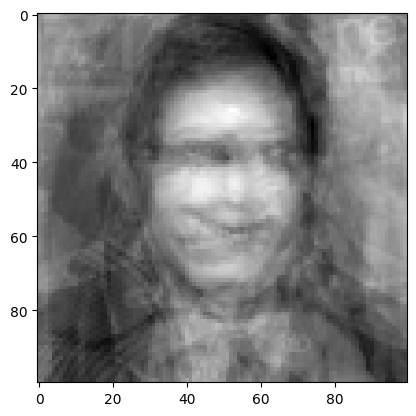

In [11]:
import matplotlib.pyplot as plt
plt.imshow(mean_value.reshape(100, 100),cmap='gray')

In [12]:
value_clean = values - mean_value

# **PCA**

In [13]:
import numpy as np
from sklearn.decomposition import PCA

In [14]:
pca =PCA(n_components=None, whiten=True, svd_solver='auto')
pca.fit(value_clean)

PCA(whiten=True)

In [15]:
exp_df = pd.DataFrame({
    "explained_var": pca.explained_variance_ratio_,
    "cum_explained_var": pca.explained_variance_ratio_.cumsum(),
    "eigen_value": pca.explained_variance_,
    "pricipal_components": np.arange(1, len(pca.explained_variance_ratio_) + 1)
})

In [16]:
exp_df.head()

,explained_var,cum_explained_var,eigen_value,pricipal_components
0,0.332593,0.332593,239.321667,1
1,0.131658,0.464251,94.736261,2
2,0.093295,0.557546,67.131780,3
3,0.075076,0.632622,54.021563,4
4,0.063387,0.696008,45.610670,5


In [17]:
exp_df.tail()

,explained_var,cum_explained_var,eigen_value,pricipal_components
14,1.410977e-02,0.969128,1.015287e+01,15
15,1.185576e-02,0.980984,8.530968e+00,16
16,9.934887e-03,0.990919,7.148778e+00,17
17,9.080889e-03,1.000000,6.534273e+00,18
18,7.297370e-32,1.000000,5.250918e-29,19


In [18]:
exp_df.set_index("pricipal_components", inplace=True)

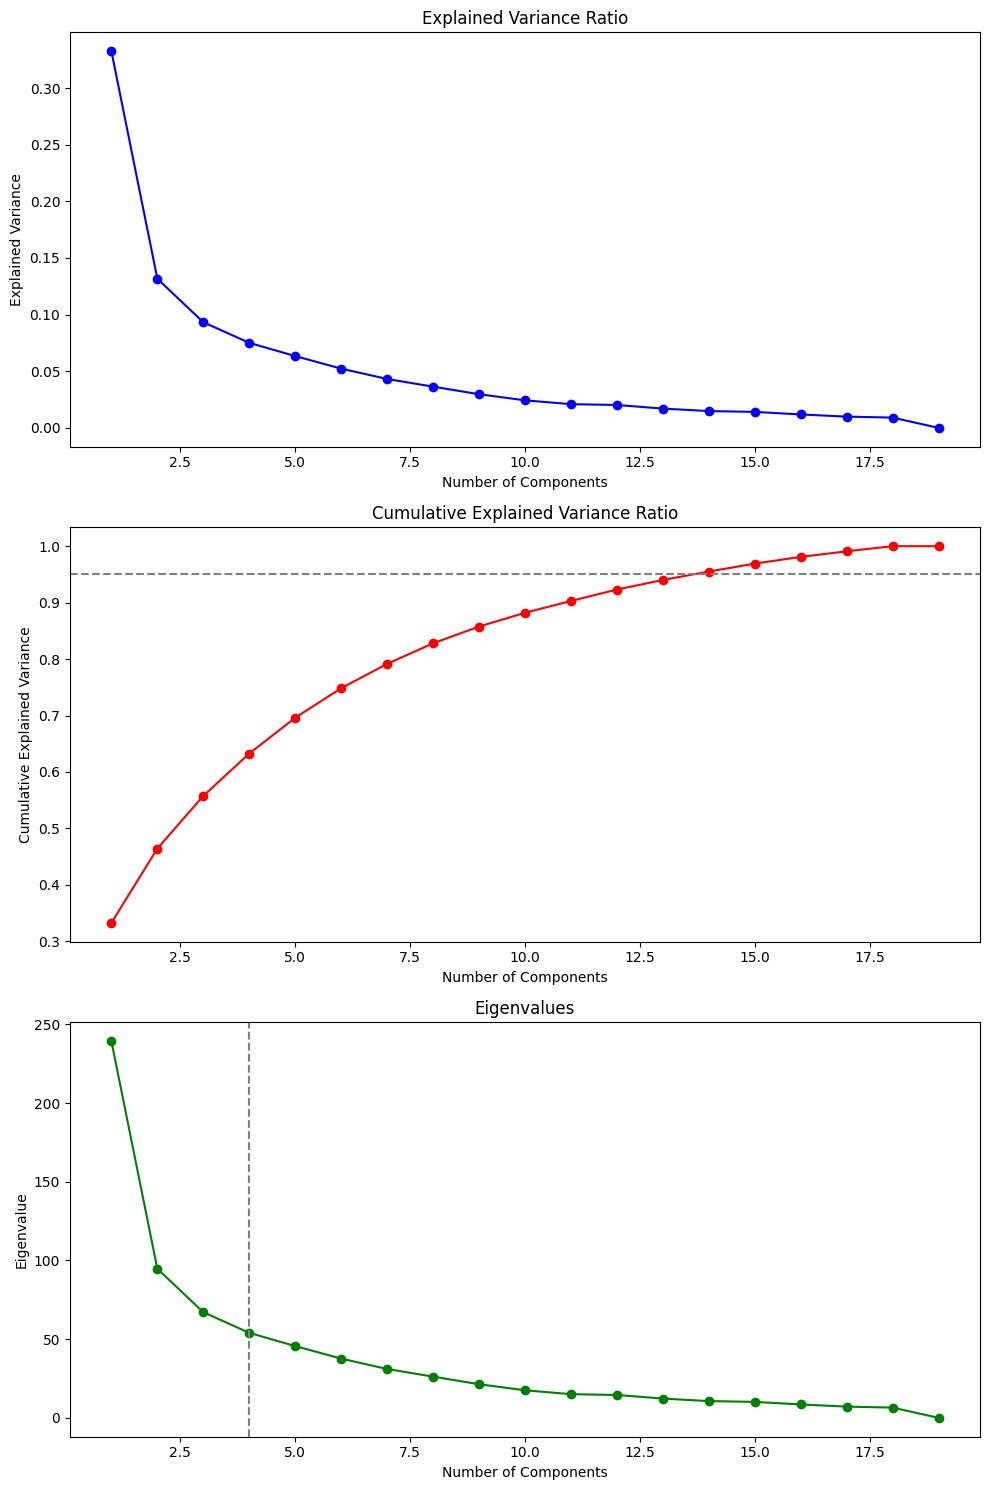

In [19]:
fig, ax = plt.subplots(nrows=3, figsize=(10, 15))
ax[0].plot(exp_df["explained_var"], marker='o', linestyle='-', color='b')
ax[0].set_title('Explained Variance Ratio')
ax[0].set_xlabel('Number of Components')
ax[0].set_ylabel('Explained Variance')


ax[1].plot(exp_df["cum_explained_var"], marker='o', linestyle='-', color='r')
ax[1].set_title('Cumulative Explained Variance Ratio')
ax[1].set_xlabel('Number of Components')
ax[1].set_ylabel('Cumulative Explained Variance')

ax[1].axhline(y=0.95, color='gray', linestyle='--')

ax[2].plot(exp_df["eigen_value"], marker='o', linestyle='-', color='g')
ax[2].set_title('Eigenvalues')
ax[2].set_xlabel('Number of Components')
ax[2].set_ylabel('Eigenvalue')

ax[2].axvline(x=4, color='gray', linestyle='--')

plt.tight_layout()
plt.show()


In [20]:
from sklearn.decomposition import PCA
n_components = exp_df.shape[0] // 2
pca_100 = PCA(n_components=n_components, whiten=True, svd_solver='auto')
pca_data = pca_100.fit_transform(value_clean)


In [21]:

desired_cum_explained_variance = 0.95
cum_explained_variance = pca.explained_variance_ratio_.cumsum()
n_components_optimal = np.argmax(cum_explained_variance >= desired_cum_explained_variance) + 1


In [22]:

pca_optimal = PCA(n_components=n_components_optimal, whiten=True, svd_solver='auto')
pca_data_optimal = pca_optimal.fit_transform(value_clean)


In [23]:
import mlflow

mlflow.set_tracking_uri("http://mlflow_server:5000")



In [24]:
mlflow.set_experiment("Face ML")

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1726425399372, experiment_id='1', last_update_time=1726425399372, lifecycle_stage='active', name='Face ML', tags={}>

In [25]:


# mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns --host 0.0.0.0 -p 5000


In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create the DataFrame as before
exp_df = pd.DataFrame({ 
    "explained_var": pca.explained_variance_ratio_,
    "cum_explained_var": pca.explained_variance_ratio_.cumsum(),
    "eigen_value": pca.explained_variance_,
    "principal_components": np.arange(1, len(pca.explained_variance_ratio_) + 1)
})

# Plotting
fig, ax = plt.subplots(nrows=3, figsize=(10, 15))

# Explained Variance Ratio
ax[0].plot(exp_df["principal_components"], exp_df["explained_var"], marker='o', linestyle='-', color='b')
ax[0].set_title('Explained Variance Ratio')
ax[0].set_xlabel('Number of Components')
ax[0].set_ylabel('Explained Variance')


ax[1].plot(exp_df["principal_components"], exp_df["cum_explained_var"], marker='o', linestyle='-', color='r')
ax[1].set_title('Cumulative Explained Variance Ratio')
ax[1].set_xlabel('Number of Components')
ax[1].set_ylabel('Cumulative Explained Variance')
ax[1].axhline(y=desired_cum_explained_variance, color='gray', linestyle='--')


ax[2].plot(exp_df["principal_components"], exp_df["eigen_value"], marker='o', linestyle='-', color='g')
ax[2].set_title('Eigenvalues')
ax[2].set_xlabel('Number of Components')
ax[2].set_ylabel('Eigenvalue')
ax[2].axvline(x=n_components_optimal, color='gray', linestyle='--')

plt.tight_layout()


plot_path = "pca_analysis_plots.png"
plt.savefig(plot_path)
plt.close()


In [27]:
with mlflow.start_run():
    mlflow.sklearn.log_model(pca_optimal, "pca_model_optimal")
    mlflow.log_param("n_components_optimal", n_components_optimal)
    mlflow.log_param("desired_cum_explained_variance", desired_cum_explained_variance)
    mlflow.log_param("whiten", pca_optimal.whiten)
    mlflow.log_param("svd_solver", pca_optimal.svd_solver)
    mlflow.log_metric("cum_explained_variance_optimal", cum_explained_variance[n_components_optimal - 1])
    mlflow.log_artifact(plot_path)
    exp_df.to_csv("pca_explained_variance.csv", index=False)
    mlflow.log_artifact("pca_explained_variance.csv")


2024/09/15 18:42:01 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/09/15 18:42:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/15 18:42:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run luxuriant-wren-30 at: http://mlflow_server:5000/#/experiments/1/runs/a96af212397749d680e813f189f5d1a5.
2024/09/15 18:42:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow_server:5000/#/experiments/1.


# **Saving models and data**